In [376]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [377]:
#df = pd.read_csv('../elena/barros_2011_training.csv')
df = pd.read_csv('../data/training_final_latcorr.csv')

## Clean / Reverse Engineer Features
- Electricity generated (kWh)
- Drop redundant columns
- Drop non-lc columns

In [378]:
df['kWh'] = df['Area_km2'] / df['Area / Electricity']
df = df.drop(['Longitude', 'Latitude','CO2 (g/kWh)', 'CH4 (g/kWh)', 'Area / Electricity', 'Name', 'field_1',
              'temp_spring_avg', 'temp_summer_avg', 'temp_fall_avg', 'temp_winter_avg', 
              'NDVI_spring_avg', 'NDVI_summer_avg', 'NDVI_fall_avg', 'NDVI_winter_avg', 
              'npp_spring_avg' , 'npp_summer_avg' , 'npp_fall_avg' , 'npp_winter_avg'], axis=1)

In [379]:
df.columns

Index(['CO2 (mg C m¯² d¯¹)', 'CH4 (mg C m-2 d-1)', 'Area_km2', 'Age',
       'Volume_km3', 'Areakm2_div_Volkm3', 'org_c', 'temp_annual_avg',
       'temp_spring_avg_lc', 'temp_summer_avg_lc', 'temp_fall_avg_lc',
       'temp_winter_avg_lc', 'NDVI_annual_avg', 'NDVI_spring_avg_lc',
       'NDVI_summer_avg_lc', 'NDVI_fall_avg_lc', 'NDVI_winter_avg_lc',
       'npp_annual_avg', 'npp_spring_avg_lc', 'npp_summer_avg_lc',
       'npp_fall_avg_lc', 'npp_winter_avg_lc', 'erosion', 'precip', 'kWh'],
      dtype='object')

In [380]:
df.shape

(154, 25)

In [ ]:
#create co2 df

In [381]:
co2 = df.drop(['CH4 (mg C m-2 d-1)'], axis=1)
co2 = co2[co2['CO2 (mg C m¯² d¯¹)'].notna()]

## XGBoost

In [382]:
X = co2.drop('CO2 (mg C m¯² d¯¹)', axis=1)
Y = co2['CO2 (mg C m¯² d¯¹)']

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42)

In [383]:
import xgboost

In [384]:
xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(x_train, y_train)
y_predict = xgb_reg.predict(x_train)

In [385]:
print('train r2:', xgb_reg.score(x_train, y_train))
print('test r2 :', xgb_reg.score(x_test, y_test))

train r2: 0.9896469776668645
test r2 : 0.01328621286666476


In [386]:
xgb_reg.fit(x_train, y_train,
           eval_set=[(x_val, y_val)], early_stopping_rounds=2)

[0]	validation_0-rmse:721.16870
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:583.60352
[2]	validation_0-rmse:507.99374
[3]	validation_0-rmse:457.99149
[4]	validation_0-rmse:432.10147
[5]	validation_0-rmse:425.71744
[6]	validation_0-rmse:422.58069
[7]	validation_0-rmse:418.34064
[8]	validation_0-rmse:419.13281
[9]	validation_0-rmse:426.50302
Stopping. Best iteration:
[7]	validation_0-rmse:418.34064



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [387]:
print('train r2:', xgb_reg.score(x_train, y_train))
print('test r2 :', xgb_reg.score(x_test, y_test))

train r2: 0.9300556201415878
test r2 : 0.29784523488377146


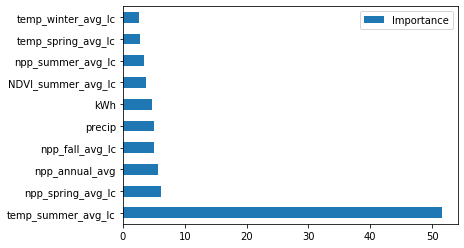

In [388]:
# list(zip(x_train.columns, xgb_reg.feature_importances_))
pd.DataFrame(index=x_train.columns, data=xgb_reg.feature_importances_*100, columns=['Importance']).sort_values(by='Importance', ascending=False).head(10).plot(kind='barh')



#### comparing predictions to actual values
- are there patterns we can see where residuals are low or high?

In [242]:
predictions = pd.DataFrame(columns=['actual','predicted'], data=list(zip(y_test, xgb_reg.predict(x_test))))

In [243]:
comparing = x_test.copy().reset_index().drop(['index'], axis=1)
comparing['actual'] = predictions['actual']
comparing['predicted'] = predictions['predicted']

### scaling values

In [389]:
from sklearn.preprocessing import StandardScaler

data = co2.copy()
scaler = StandardScaler()
co2_scaled = pd.DataFrame(scaler.fit_transform(data),columns=co2.columns)

In [390]:
X = co2_scaled.drop('CO2 (mg C m¯² d¯¹)', axis=1)
Y = co2['CO2 (mg C m¯² d¯¹)']

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [391]:
xgb_reg2 = xgboost.XGBRegressor()
xgb_reg2.fit(x_train, y_train, 
             eval_set=[(x_val, y_val)], 
             early_stopping_rounds=5)

[0]	validation_0-rmse:773.44659
Will train until validation_0-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:636.62592
[2]	validation_0-rmse:555.69629
[3]	validation_0-rmse:531.17535
[4]	validation_0-rmse:513.17163
[5]	validation_0-rmse:500.26703
[6]	validation_0-rmse:486.00000
[7]	validation_0-rmse:476.97626
[8]	validation_0-rmse:474.36438
[9]	validation_0-rmse:474.52478
[10]	validation_0-rmse:475.64081
[11]	validation_0-rmse:476.98248
[12]	validation_0-rmse:479.71167
[13]	validation_0-rmse:479.70795
Stopping. Best iteration:
[8]	validation_0-rmse:474.36438



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [392]:
print('train r2:', xgb_reg2.score(x_train, y_train))
print('test  r2:', xgb_reg2.score(x_test, y_test))

train r2: 0.9468081292370588
test  r2: 0.4443317645867686


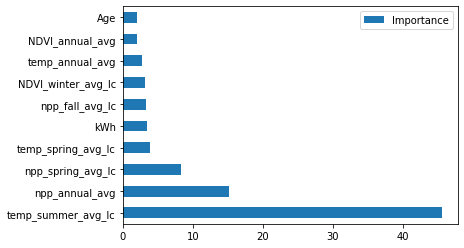

In [393]:
pd.DataFrame(index=x_train.columns, data=xgb_reg2.feature_importances_*100, columns=['Importance']).sort_values(by='Importance', ascending=False).head(10).plot(kind='barh')

## grid search

In [263]:
from sklearn.model_selection import GridSearchCV

grid_values = {
    "n_estimators": range(0,100,10),
    "learning_rate" : np.linspace(.001,.5,10),
    "max_depth" : range(1,11)
}

grid_search_xgb = GridSearchCV(xgb_reg2, grid_values, scoring='r2', cv=2, n_jobs=-1)
%time grid_search_xgb.fit(x_train, y_train)

CPU times: user 3.92 s, sys: 81 ms, total: 4 s
Wall time: 16.2 s


GridSearchCV(cv=2, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0, gpu_id=-1,
                                    importance_type='gain',
                                    interaction_constraints='',
                                    learning_rate=0.300000012, max_delta_step=0,
                                    max_depth=6, min_child_weight=1,
                                    missing=nan, monotone_constraints='()',
                                    n_estimators=100, n_jobs...
                                    tree_method='exact', validate_parameters=1,
                                    verbosity=None),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': array([0.001     , 0.05644444, 0.11188889, 0.16733333, 0.22277778,
       0.27822222, 0.33366667, 0.38911111, 

In [394]:
grid_search_xgb.best_params_

{'learning_rate': 0.2782222222222222, 'max_depth': 2, 'n_estimators': 10}

In [395]:
grid_search_xgb.best_score_

0.3116559366290087

In [396]:
xgb_best = xgboost.XGBRegressor(learning_rate=.2782, n_estimators=10, max_depth=2)
xgb_best.fit(x_train, y_train, 
             eval_set=[(x_val, y_val)], 
             early_stopping_rounds=10)

print('')
print('train r2:', xgb_best.score(x_train, y_train))
print('test  r2:', xgb_best.score(x_test, y_test))

[0]	validation_0-rmse:796.10706
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:674.35614
[2]	validation_0-rmse:588.64453
[3]	validation_0-rmse:557.90723
[4]	validation_0-rmse:549.00391
[5]	validation_0-rmse:526.26422
[6]	validation_0-rmse:523.37030
[7]	validation_0-rmse:509.99744
[8]	validation_0-rmse:501.52414
[9]	validation_0-rmse:504.21951

train r2: 0.7207922231108306
test  r2: 0.3922345049279864


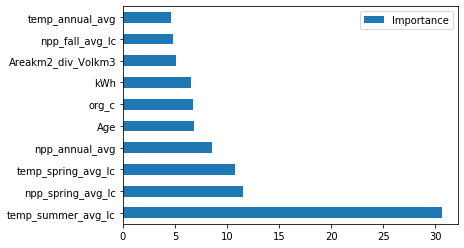

In [397]:
pd.DataFrame(index=x_train.columns, data=xgb_best.feature_importances_*100, columns=['Importance']).sort_values(by='Importance', ascending=False).head(10).plot(kind='barh')


In [398]:
predictions = pd.DataFrame(columns=['actual','predicted'], data=list(zip(y_test, xgb_reg.predict(x_test))))

comparing = x_test.copy().reset_index().drop(['index'], axis=1)
comparing['actual'] = predictions['actual']
comparing['predicted'] = predictions['predicted']
comparing['error'] = abs(comparing['actual'] - comparing['predicted'])/comparing['actual']

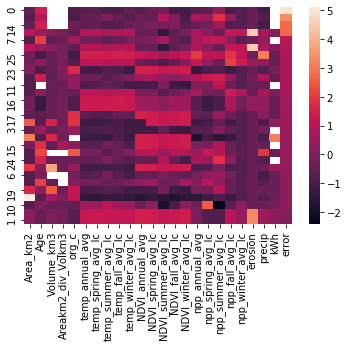

In [399]:
import seaborn as sns

pd.options.display.max_rows = None
pd.options.display.max_columns = None

sns.heatmap(comparing.sort_values(by='error', ascending=False).drop(['actual','predicted'],axis=1))

In [ ]:
##try with imputing NaNs in the train set:

In [400]:
from sklearn.impute import KNNImputer
model_impute = KNNImputer(n_neighbors=int(np.sqrt(x_train.shape[0])))
x_train_imputed = model_impute.fit_transform(x_train)

x_train_imputed = pd.DataFrame(columns=x_train.columns, data=x_train_imputed)

#check
for column in x_train:
    print(column, ':',  x_train_imputed[column].isna().sum())

Area_km2 : 0
Age : 0
Volume_km3 : 0
Areakm2_div_Volkm3 : 0
org_c : 0
temp_annual_avg : 0
temp_spring_avg_lc : 0
temp_summer_avg_lc : 0
temp_fall_avg_lc : 0
temp_winter_avg_lc : 0
NDVI_annual_avg : 0
NDVI_spring_avg_lc : 0
NDVI_summer_avg_lc : 0
NDVI_fall_avg_lc : 0
NDVI_winter_avg_lc : 0
npp_annual_avg : 0
npp_spring_avg_lc : 0
npp_summer_avg_lc : 0
npp_fall_avg_lc : 0
npp_winter_avg_lc : 0
erosion : 0
precip : 0
kWh : 0


In [401]:
xgb_reg_imputed = xgboost.XGBRegressor()
xgb_reg_imputed.fit(x_train_imputed, y_train, 
             eval_set=[(x_val, y_val)], 
             early_stopping_rounds=5)

[0]	validation_0-rmse:772.04333
Will train until validation_0-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:630.87427
[2]	validation_0-rmse:582.48187
[3]	validation_0-rmse:531.15790
[4]	validation_0-rmse:498.47775
[5]	validation_0-rmse:474.54703
[6]	validation_0-rmse:477.85489
[7]	validation_0-rmse:468.29495
[8]	validation_0-rmse:468.35754
[9]	validation_0-rmse:469.05930
[10]	validation_0-rmse:470.20474
[11]	validation_0-rmse:471.00882
[12]	validation_0-rmse:470.31238
Stopping. Best iteration:
[7]	validation_0-rmse:468.29495



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [402]:
print('train r2:', xgb_reg_imputed.score(x_train, y_train))
print('test  r2:', xgb_reg_imputed.score(x_test, y_test))

train r2: 0.9115157401373564
test  r2: 0.4565385091077107


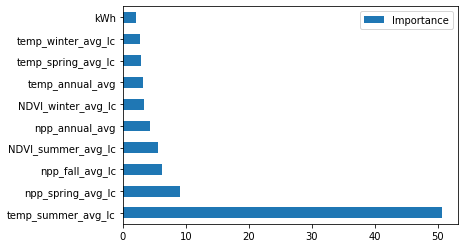

In [403]:
pd.DataFrame(index=x_train.columns, data=xgb_reg_imputed.feature_importances_*100, columns=['Importance']).sort_values(by='Importance', ascending=False).head(10).plot(kind='barh')


In [306]:
from sklearn.model_selection import GridSearchCV

grid_values = {
    "n_estimators": range(0,100,10),
    "learning_rate" : np.linspace(.001,.5,10),
    "max_depth" : range(1,11)
}

grid_search_xgb_imputed = GridSearchCV(xgb_reg_imputed, grid_values, scoring='r2', cv=2, n_jobs=-1)
%time grid_search_xgb_imputed.fit(x_train_imputed, y_train)

CPU times: user 4.2 s, sys: 168 ms, total: 4.37 s
Wall time: 25.1 s


GridSearchCV(cv=2, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0, gpu_id=-1,
                                    importance_type='gain',
                                    interaction_constraints='',
                                    learning_rate=0.300000012, max_delta_step=0,
                                    max_depth=6, min_child_weight=1,
                                    missing=nan, monotone_constraints='()',
                                    n_estimators=100, n_jobs...
                                    tree_method='exact', validate_parameters=1,
                                    verbosity=None),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': array([0.001     , 0.05644444, 0.11188889, 0.16733333, 0.22277778,
       0.27822222, 0.33366667, 0.38911111, 

In [308]:
grid_search_xgb_imputed.best_params_

{'learning_rate': 0.33366666666666667, 'max_depth': 2, 'n_estimators': 20}

In [309]:
grid_search_xgb_imputed.best_score_

0.31955231769915665

In [404]:
xgb_best2 = xgboost.XGBRegressor(learning_rate=.33367, n_estimators=20, max_depth=2)
xgb_best2.fit(x_train, y_train, 
             eval_set=[(x_val, y_val)], 
             early_stopping_rounds=10)

print('')
print('train r2:', xgb_best2.score(x_train, y_train))
print('test  r2:', xgb_best2.score(x_test, y_test))

[0]	validation_0-rmse:765.30719
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:625.00842
[2]	validation_0-rmse:578.60193
[3]	validation_0-rmse:536.88568
[4]	validation_0-rmse:538.29126
[5]	validation_0-rmse:525.58832
[6]	validation_0-rmse:499.24795
[7]	validation_0-rmse:502.21670
[8]	validation_0-rmse:496.35919
[9]	validation_0-rmse:488.48654
[10]	validation_0-rmse:487.58347
[11]	validation_0-rmse:483.63208
[12]	validation_0-rmse:482.99573
[13]	validation_0-rmse:491.59503
[14]	validation_0-rmse:495.03070
[15]	validation_0-rmse:490.02710
[16]	validation_0-rmse:484.79968
[17]	validation_0-rmse:483.41147
[18]	validation_0-rmse:487.18912
[19]	validation_0-rmse:485.40842

train r2: 0.8367650389389587
test  r2: 0.3255876759944524


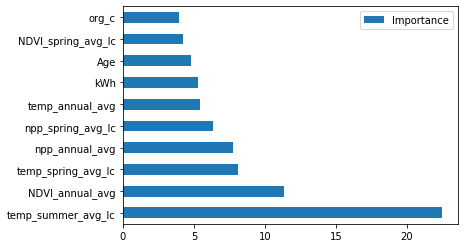

In [405]:
pd.DataFrame(index=x_train.columns, data=xgb_best2.feature_importances_*100, columns=['Importance']).sort_values(by='Importance', ascending=False).head(10).plot(kind='barh')

In [ ]:
## try cutting down the number of features - maybe theres too much noise:

In [406]:
X.columns

Index(['Area_km2', 'Age', 'Volume_km3', 'Areakm2_div_Volkm3', 'org_c',
       'temp_annual_avg', 'temp_spring_avg_lc', 'temp_summer_avg_lc',
       'temp_fall_avg_lc', 'temp_winter_avg_lc', 'NDVI_annual_avg',
       'NDVI_spring_avg_lc', 'NDVI_summer_avg_lc', 'NDVI_fall_avg_lc',
       'NDVI_winter_avg_lc', 'npp_annual_avg', 'npp_spring_avg_lc',
       'npp_summer_avg_lc', 'npp_fall_avg_lc', 'npp_winter_avg_lc', 'erosion',
       'precip', 'kWh'],
      dtype='object')

In [407]:
X_reduced = X[['Area_km2', 'Age', 'Volume_km3', 'Areakm2_div_Volkm3', 'org_c',
       'temp_summer_avg_lc', 'temp_winter_avg_lc', 'NDVI_annual_avg', 'npp_annual_avg',
       'erosion', 'precip', 'kWh']]

In [408]:
x_train, x_test, y_train, y_test = train_test_split(X_reduced, Y, test_size=0.2, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [409]:
model_impute = KNNImputer(n_neighbors=int(np.sqrt(x_train.shape[0])))
x_train_imputed = model_impute.fit_transform(x_train)
x_train_imputed = pd.DataFrame(columns=x_train.columns, data=x_train_imputed)


xgb_reg_imputed2 = xgboost.XGBRegressor()
xgb_reg_imputed2.fit(x_train_imputed, y_train, 
             eval_set=[(x_val, y_val)], 
             early_stopping_rounds=5)

print('')
print('train r2:', xgb_reg_imputed2.score(x_train, y_train))
print('test  r2:', xgb_reg_imputed2.score(x_test, y_test))

[0]	validation_0-rmse:764.53656
Will train until validation_0-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:620.79987
[2]	validation_0-rmse:538.73157
[3]	validation_0-rmse:521.13440
[4]	validation_0-rmse:510.29352
[5]	validation_0-rmse:499.21777
[6]	validation_0-rmse:500.76053
[7]	validation_0-rmse:500.27597
[8]	validation_0-rmse:504.98541
[9]	validation_0-rmse:504.69574
[10]	validation_0-rmse:503.56076
Stopping. Best iteration:
[5]	validation_0-rmse:499.21777


train r2: 0.8295311517404469
test  r2: 0.1313537425721616
